In [1]:
import os
from collections import OrderedDict

import torch
import torch.optim

from latent_rationale.sst.vocabulary import Vocabulary
from latent_rationale.sst.models.model_helpers import build_model
from latent_rationale.sst.util import get_predict_args, sst_reader, \
    load_glove, print_parameters, get_device, find_ckpt_in_directory, \
    plot_dataset
from latent_rationale.sst.evaluate import evaluate, predict


from latent_rationale.sst.util import Example
from IPython.display import Image
import os

Point to codebase

In [2]:
cd /home/wferrei1/github/probabll/interpretable_predictions

/home/wferrei1/github/probabll/interpretable_predictions


In [3]:
def config(ckpt, verbose=False):
    """
    Loads a trained model stored in a directory `ckpt`.
    Returns
        - cfg: dict of options
        - ckpt: trained model
        - device: 
        - model:
    """
    device = get_device()
    ckpt_path = find_ckpt_in_directory(ckpt)
    ckpt = torch.load(ckpt_path, map_location=device)
    cfg = ckpt["cfg"]
    if verbose:
        for k, v in cfg.items():
            print("{:20} : {:10}".format(k, v)) 
                    
    batch_size = cfg.get("eval_batch_size", 25)

    vocab = Vocabulary()
    vectors = load_glove(cfg["word_vectors"], vocab)  # this populates vocab

    # Map the sentiment labels 0-4 to a more readable form (and the opposite)
    i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
    t2i = OrderedDict({p: i for p, i in zip(i2t, range(len(i2t)))})

    # Build model
    model = build_model(cfg["model"], vocab, t2i, cfg)

    # load parameters from checkpoint into model
    model.load_state_dict(ckpt["state_dict"])
    model.to(device)
        
    return cfg, ckpt, device, model

def validate(cfg, model, device):
    dev_data = list(sst_reader("data/sst/dev.txt"))
    dev_eval = evaluate(model, dev_data, batch_size=cfg.get("eval_batch_size", 25), device=device)
    print("dev acc", dev_eval["acc"])

In [4]:
cfg, ckpt, device, model = config('pretrained/beer_latent_30pct')

Classifier #params: 543905
IndependentLatentModel #params: 543002


In [5]:
validate(cfg, model, device)

dev acc 0.4595821980013991


In [10]:
def demo(sentence, label=None, labels=None, writeto='tmp'):
    if type(sentence) is str:
        sentence = sentence.split()
    instance = Example(
        sentence, 
        0 if label is None else label, 
        [0] * len(sentence) if labels is None else labels
    )
    data = [instance]
    _, preds = predict(model, data, batch_size=1, device=device)
    print("Target %s Prediction %d" % ('?' if label is None else label, preds[0]))
    if writeto:
        os.makedirs(writeto, exist_ok=True)    
        plot_dataset(model, data, batch_size=1, device=device, save_path=writeto, ext='png')
        return Image(filename='%s/plot0000.z.png' % writeto)

In [11]:
dev_data = list(sst_reader("data/sst/dev.txt"))

Target ? Prediction 3


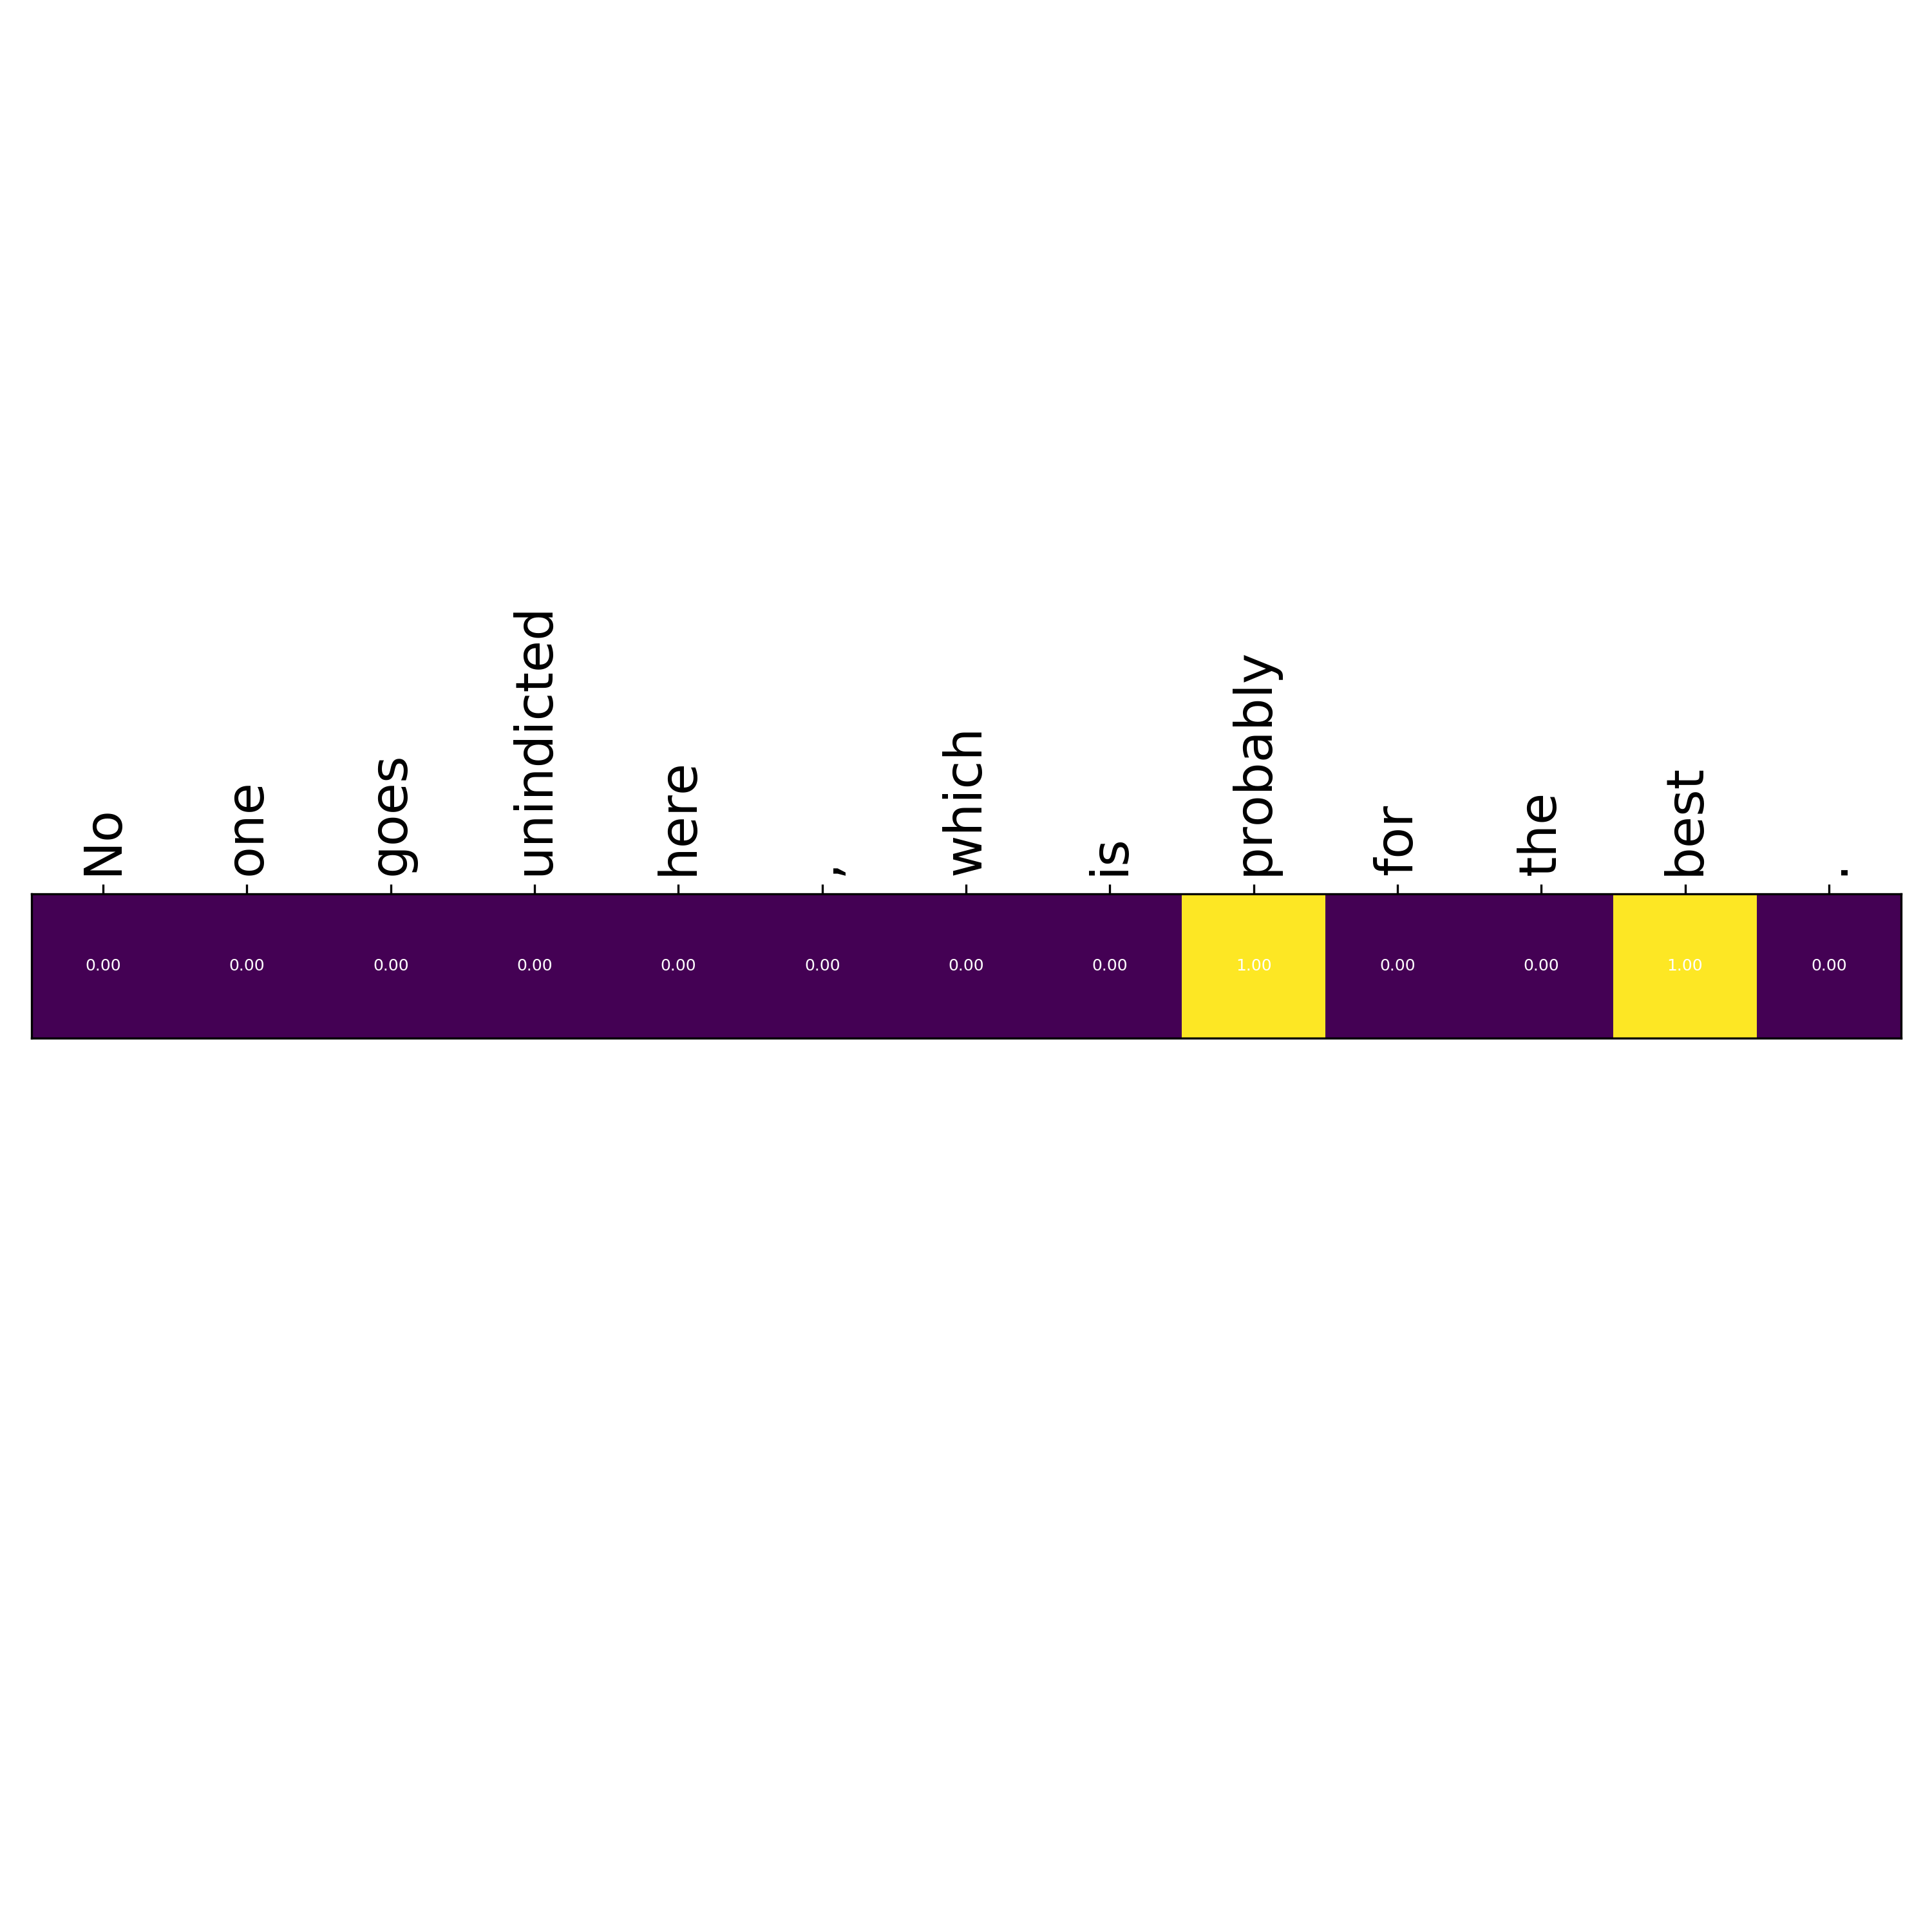

In [13]:
demo(dev_data[1].tokens, writeto='demo/1')